In [1]:
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = (8, 7)
    plt.style.use('fivethirtyeight')

    import warnings
    warnings.filterwarnings('ignore')

    import yfinance as yf

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (roc_auc_score
                                 , precision_score
                                 , recall_score
                                 , roc_curve
                                 , confusion_matrix
                                 , plot_confusion_matrix
                                 , precision_recall_curve
                                 , auc
                                )

In [2]:
def direction(interval = '1d'
              , history = '10y'
              , perc_inc = 0.015
              , symbol = 'IYW'
              , perc_train = 0.333
              , load_new = 0 
             ):
    
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = (8, 7)
    plt.style.use('fivethirtyeight')

    import warnings
    warnings.filterwarnings('ignore')

    import yfinance as yf

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (roc_auc_score
                                 , precision_score
                                 , recall_score
                                 , roc_curve
                                 , confusion_matrix
                                 , plot_confusion_matrix
                                 , precision_recall_curve
                                 , auc
                                )
    
    # Load New From Server
    if load_new == 1:
        stock_df = yf.download(tickers = symbol # symbol of stock 

                           , period = history # length of history back in time

                           , interval = interval # time periods of subinterval e.g. 1m or 1hr

                           # , start = start # start date, time

                           # , end = end # end date, time

                           , prepost = True # pre/post market data
                          )
        # Create Percent Change
        stock_df['percent change'] = (stock_df.Open - stock_df.Close) / stock_df.Open

        #create decision column
        stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc

                                        , 1  # 1 if up % or greater

                                        , 0  # 0 if not up % or greater

                                       )
        # create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions

        # Save DF to CSV
        stock_df.to_csv('stock_df.csv')
        
    else:
        stock_df = pd.read_csv('stock_df.csv', index_col='Datetime')
        # create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions
 
    # balance the data
    ones = stock_df_one_off.decision.value_counts()[1]
    stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)
    
    # check for NaN's
    stock_df_bal.dropna(axis=0, inplace=True)
    
    # Train Test Split
    X = stock_df_bal.drop(columns=['percent change', 'decision']) # get columns other than decision
    y = stock_df_bal['decision'] # get decision column
    
    X_train, X_test, y_train, y_test = train_test_split(X
                                                        , y
                                                        , test_size=0.20
                                                        , random_state = 42
                                                       )
    
    # random forest classifier rfc
    rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                                 , max_depth = 3
                                 , max_features = 4
                                 , random_state = 42
                                 , verbose=0 # no showing backend work
                                 , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                )
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_probs = rfc.predict_proba(X_test)[:, 1]
    
    # ROC Value
    roc_value = roc_auc_score(y_test
                              , y_probs
                             )
    
    # AUC Score
    rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
    auc_value = round(auc(rf_recall, rf_prec), 3)
    
    # Feature Importances
    # feature_df = pd.DataFrame({'feature': X_train.columns
    #                            , 'importances': rfc.feature_importances_
    #                           }
    #                          ).sort_values('importances', ascending=False)
    
    # Prediction
    last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[-1]
    if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
        result = f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.'
    else:
        result = f'Sell or hold {symbol} on the {interval} interval.'
        
    return ones, roc_value, auc_value, result

In [3]:
ones, roc, auc, result = direction(interval = '60m'
                                   , history = '2y'
                                   , perc_inc = 0.005
                                   , symbol = 'IYW'
                                   , perc_train = 0.15
                                   , load_new = 1
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

[*********************100%***********************]  1 of 1 completed
Positives: 290
ROC Score: 0.62
AUC Score: 0.49
Sell or hold IYW on the 60m interval.


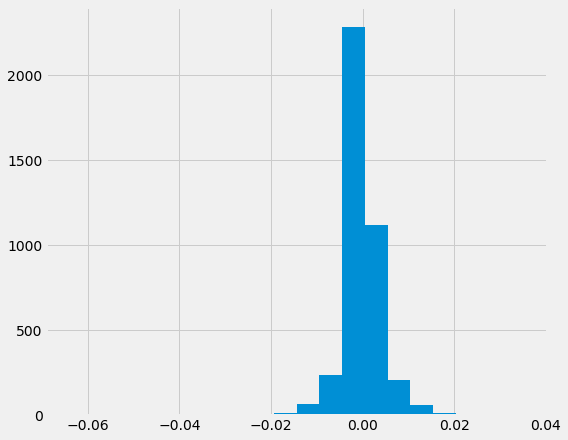

In [4]:
stock_df = pd.read_csv('stock_df.csv', index_col='Datetime') # 'Date' for 1d, 'Datetime' for 60m
stock_df['percent change'].hist(bins=20)

In [5]:
stock_df['percent change'].quantile([0.84])

0.84    0.002662
Name: percent change, dtype: float64

In [6]:
perc = [x*0.01 for x in range(5,105, 5)]
perc

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.85,
 0.9,
 0.9500000000000001,
 1.0]

In [7]:
roc_lst = []
auc_lst = []
results_lst = []
perc = [x*0.01 for x in range(5,105, 5)]

for x in perc:
    ones, roc, auc, result = direction(interval = '60m'
                                       , history = '2y'
                                       , perc_inc = 0.005
                                       , symbol = 'IYW'
                                       , perc_train = x
                                       , load_new = 0
                                      )
    roc_lst.append(roc)
    auc_lst.append(auc)
    results_lst.append(result)

results_df = pd.DataFrame({'Percent': perc
                           , 'ROC': roc_lst
                           , 'AUC': auc_lst
                           , 'Result': results_lst
                          }
                         )

In [8]:
results_df

,Percent,ROC,AUC,Result
0,0.05,0.690984,0.535,Sell or hold IYW on the 60m interval.
1,0.10,0.723881,0.610,Buy IYW on the 60m interval for 0.5% increase.
2,0.15,0.625800,0.486,Buy IYW on the 60m interval for 0.5% increase.
3,0.20,0.605239,0.566,Buy IYW on the 60m interval for 0.5% increase.
4,0.25,0.609504,0.536,Sell or hold IYW on the 60m interval.
5,0.30,0.684740,0.653,Buy IYW on the 60m interval for 0.5% increase.
6,0.35,0.666920,0.542,Buy IYW on the 60m interval for 0.5% increase.
7,0.40,0.720987,0.561,Sell or hold IYW on the 60m interval.
8,0.45,0.717941,0.630,Buy IYW on the 60m interval for 0.5% increase.
9,0.50,0.690070,0.619,Buy IYW on the 60m interval for 0.5% increase.


In [9]:
results_df.Result.value_counts()

Buy IYW on the 60m interval for 0.5% increase.    14
Sell or hold IYW on the 60m interval.              6
Name: Result, dtype: int64

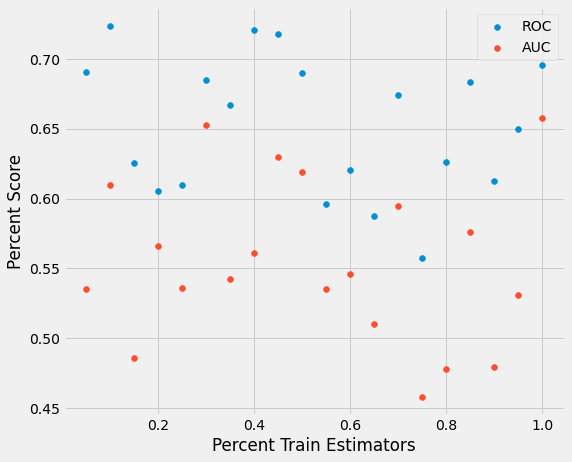

In [10]:
plt.scatter(results_df.Percent
            , results_df.ROC
            , label = 'ROC'
           )
plt.scatter(results_df.Percent
            , results_df.AUC
            , label = 'AUC'
           )
plt.xlabel('Percent Train Estimators')
plt.ylabel('Percent Score')
plt.legend();


In [11]:
results_df.loc[results_df.ROC == results_df.ROC.max()]

,Percent,ROC,AUC,Result
1,0.1,0.723881,0.61,Buy IYW on the 60m interval for 0.5% increase.


In [12]:
ones, roc, auc, result = direction(interval = '60m'
                                   , history = '2y'
                                   , perc_inc = 0.03
                                   , symbol = 'IYW'
                                   , perc_train = results_df.loc[results_df.ROC == results_df.ROC.max()].Percent
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

Positives: 290
ROC Score: 0.62
AUC Score: 0.52
Buy IYW on the 60m interval for 3.0% increase.


In [13]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Datetime,,,,,,,,
2020-06-23 15:30:00-04:00,270.679901,271.170013,269.929993,270.410004,270.410004,29920,0.000997,0
2020-06-23 16:00:00-04:00,270.510000,270.510000,270.510000,270.510000,270.510000,4350,0.000000,0
2020-06-24 09:30:00-04:00,269.500000,271.070007,267.240112,268.470093,268.470093,51970,0.003822,0
2020-06-24 10:30:00-04:00,267.950012,267.950012,265.140411,265.140411,265.140411,7888,0.010486,0
2020-06-24 11:16:11-04:00,265.010010,265.010010,265.010010,265.010010,265.010010,0,0.000000,0
